# Direct Backend Interaction

This notebook demonstrates how to interact directly with the backend to generate routes, simulating the 'Generate Route' button click.

In [1]:

import os
import sys
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
from shapely.geometry import Polygon, LineString
import math
import numpy as np

# Add backend directory to path
sys.path.append('../backend')

import route_gen_logic
import utils


## Select Input Data

Define the directory containing the input GeoJSON files.

In [2]:

# Set the directory with input files
# Relative path to test data
input_directory = 'test_data/3_backend_interaciton' 
print(f"Using input directory: {input_directory}")


Using input directory: test_data/3_backend_interaciton


## Load Data

Load the GeoJSON files from the directory.

Data loaded successfully.
Holes: 19

--- Input Data Visualization ---


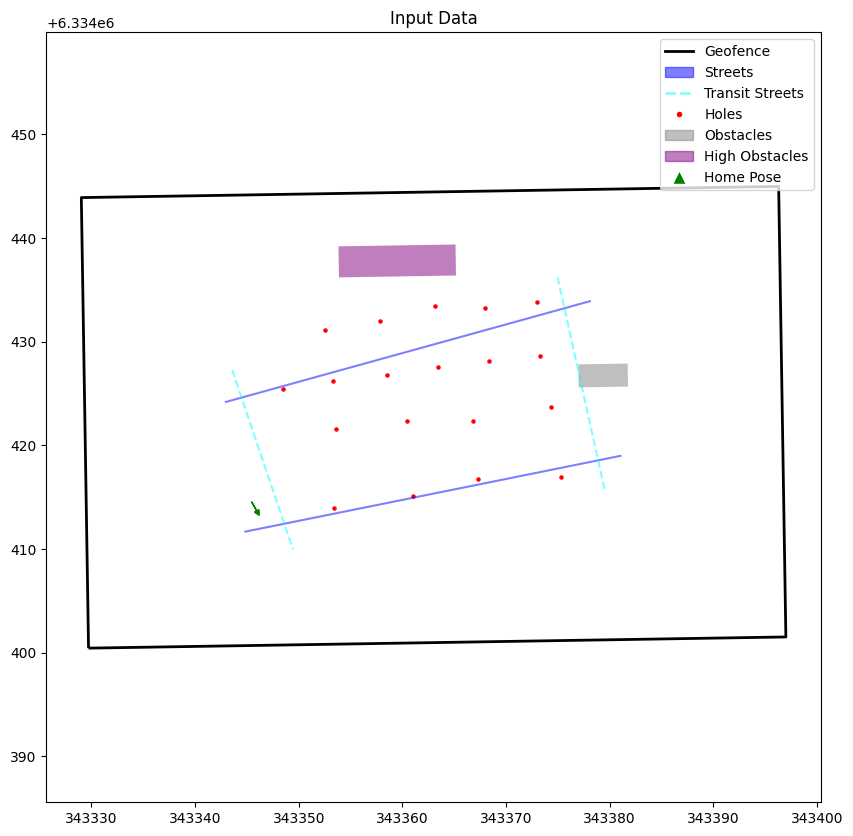

In [3]:

def load_data(directory):
    try:
        # Essential files
        geofence = gpd.read_file(os.path.join(directory, "geofence.geojson"))
        home_pose = gpd.read_file(os.path.join(directory, "home_pose.geojson"))
        streets = gpd.read_file(os.path.join(directory, "streets.geojson"))
        
        # Optional files
        try:
            transit_streets = gpd.read_file(os.path.join(directory, "transit_streets.geojson"))
        except:
            transit_streets = None
            
        try:
            obstacles = gpd.read_file(os.path.join(directory, "obstacles.geojson"))
        except:
            obstacles = None
            
        try:
            high_obstacles = gpd.read_file(os.path.join(directory, "high_obstacles.geojson"))
        except:
            high_obstacles = None
            
        # Load holes using backend utility
        # Note: The backend expects a path, so we pass the full path
        holes_path = os.path.join(directory, "holes.hol")
        if os.path.exists(holes_path):
             # utils.readHolFile expects (filename, wgs84_bool)
             # We assume WGS84=True for this test data as per common usage
             holes = utils.readHolFile(holes_path, True)
        else:
             print("No holes.hol found.")
             holes = None

        # Align CRS to holes (UTM) and apply preprocessing
        if holes is not None and holes.crs is not None:
             target_crs = holes.crs
             
             if geofence is not None: 
                 geofence = geofence.to_crs(target_crs)
                 geofence['type'] = 'geofence'
                 
             if home_pose is not None: 
                 home_pose = home_pose.to_crs(target_crs)
                 # Calculate poses for home_pose as done in main.py
                 home_pose['poses'] = [ [[home_pose.geometry[0].coords[0][0], home_pose.geometry[0].coords[0][1], math.atan2(home_pose.geometry[0].coords[1][1]-home_pose.geometry[0].coords[0][1],home_pose.geometry[0].coords[1][0]-home_pose.geometry[0].coords[0][0])]] ]
                 home_pose['type'] = 'home_pose'
                 
             if streets is not None: 
                 streets = streets.to_crs(target_crs)
                 streets['type'] = 'streets'
                 
             if transit_streets is not None: 
                 transit_streets = transit_streets.to_crs(target_crs)
                 transit_streets['type'] = 'transit_streets'
                 
             if obstacles is not None: 
                 obstacles = obstacles.to_crs(target_crs)
                 obstacles['type'] = 'obstacles'
                 
             if high_obstacles is not None: 
                 high_obstacles = high_obstacles.to_crs(target_crs)
                 high_obstacles['type'] = 'high_obstacles'

        return holes, geofence, home_pose, streets, transit_streets, obstacles, high_obstacles
    except Exception as e:
        print(f"Error loading files: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None, None, None, None, None


holes, geofence, home_pose, streets, transit_streets, obstacles, high_obstacles = load_data(input_directory)

if holes is not None:
    print("Data loaded successfully.")
    print(f"Holes: {len(holes)}")
    
    # --- Input Data Visualization ---
    print("\n--- Input Data Visualization ---")
    fig_input, ax_input = plt.subplots(figsize=(10, 10))
    
    # Imports for custom legend
    import matplotlib.patches as mpatches
    from matplotlib.lines import Line2D
    legend_elements = []
    
    if geofence is not None:
        geofence.boundary.plot(ax=ax_input, color='black', linewidth=2)
        legend_elements.append(Line2D([0], [0], color='black', lw=2, label='Geofence'))
        
    if streets is not None:
        streets.plot(ax=ax_input, color='blue', alpha=0.5)
        legend_elements.append(mpatches.Patch(color='blue', alpha=0.5, label='Streets'))
        
    if transit_streets is not None:
        transit_streets.plot(ax=ax_input, color='cyan', alpha=0.5, linestyle='--')
        legend_elements.append(Line2D([0], [0], color='cyan', alpha=0.5, linestyle='--', lw=2, label='Transit Streets'))
        
    if holes is not None:
        holes.plot(ax=ax_input, color='red', markersize=5, marker='o')
        legend_elements.append(Line2D([0], [0], marker='o', color='w', label='Holes', markerfacecolor='red', markersize=5))
        
    if obstacles is not None:
        obstacles.plot(ax=ax_input, color='gray', alpha=0.5)
        legend_elements.append(mpatches.Patch(color='gray', alpha=0.5, label='Obstacles'))
        
    if high_obstacles is not None:
        high_obstacles.plot(ax=ax_input, color='purple', alpha=0.5)
        legend_elements.append(mpatches.Patch(color='purple', alpha=0.5, label='High Obstacles'))
        
    if home_pose is not None:
        # Plot home pose as an arrow
        for idx, row in home_pose.iterrows():
            # Use the calculated poses if available
            if 'poses' in row and len(row['poses']) > 0:
                pose = row['poses'][0] # [x, y, yaw]
                x, y, yaw = pose[0], pose[1], pose[2]
                arrow_len = 1.0
                ax_input.arrow(x, y, math.cos(yaw)*arrow_len, math.sin(yaw)*arrow_len, 
                             head_width=0.5, head_length=0.5, fc='green', ec='green')
            else:
                # Fallback
                x, y = row.geometry.centroid.x, row.geometry.centroid.y
                ax_input.plot(x, y, marker='^', color='green', markersize=5)
        
        legend_elements.append(Line2D([0], [0], marker='^', color='w', label='Home Pose', markerfacecolor='green', markersize=10))
            
    ax_input.legend(handles=legend_elements, loc='upper right')
    plt.title("Input Data")
    plt.axis('equal')
    plt.show()
else:
    print("Failed to load essential data.")


## Generate Routes

Call the backend logic to generate routes.

In [4]:

if holes is not None:
    # Parameters
    use_obstacles = obstacles is not None
    use_high_obstacles = high_obstacles is not None
    use_transit_streets = transit_streets is not None
    fit_streets_enabled = True
    fit_twice = True

    # Call generation logic
    results = route_gen_logic.generate_routes_logic(
        holes,
        geofence,
        home_pose,
        streets,
        transit_streets,
        obstacles,
        high_obstacles,
        use_obstacles,
        use_high_obstacles,
        use_transit_streets,
        fit_streets_enabled,
        fit_twice
    )

    print("Route generation completed.")
else:
    print("Cannot generate routes without data.")


epoch 0 / 300   loss 249.4136199951172
epoch 50 / 300   loss 233.32431030273438
epoch 100 / 300   loss 221.41567993164062
epoch 150 / 300   loss 130.57957458496094
epoch 200 / 300   loss 89.89509582519531
epoch 250 / 300   loss 33.44077682495117
epoch 0 / 300   loss 1.4507572650909424
epoch 50 / 300   loss 1.3015023469924927
epoch 100 / 300   loss 1.247456431388855
epoch 150 / 300   loss 1.0349769592285156
epoch 200 / 300   loss 0.8779336214065552
epoch 250 / 300   loss 0.6580805778503418
epoch 0 / 300   loss 159.28982543945312
epoch 50 / 300   loss 149.9776153564453
epoch 100 / 300   loss 141.615478515625
epoch 150 / 300   loss 71.70182037353516
epoch 200 / 300   loss 41.131282806396484
epoch 250 / 300   loss 10.501128196716309
epoch 0 / 300   loss 6.422163963317871
epoch 50 / 300   loss 5.511676788330078
epoch 100 / 300   loss 4.133753776550293
epoch 150 / 300   loss 1.9811023473739624
epoch 200 / 300   loss 1.9573811292648315
epoch 250 / 300   loss 1.931432843208313
holes after filt

## Process Output

Save the results to `global_plan.csv` and visualize.

In [5]:

if 'results' in locals():
    all_together = results['all_together']
    output_csv = './generated/3_backend_interaction/global_plan.csv'
    all_together.to_csv(output_csv)
    print(f"Saved global plan to {output_csv}")
    
    # Explain global_plan.csv columns
    print("\n--- Global Plan Dataframe Structure ---")
    print("The global_plan.csv contains the following key columns:")
    print("- x, y, z: Coordinates of the points (holes, waypoints).")
    print("- drillhole_id: Identifier for the drill holes.")
    print("- type: Type of the geometry (hole, street, geofence, etc.).")
    print("- closest_street: Index of the street closest to the hole.")
    print("- graph_pose: The pose (x, y, yaw) on the graph/street for the robot to approach the hole.")
    print("- poses: List of poses for the path.")
    
    print("\nGlobal Plan Dataframe:")
    pd.set_option('display.max_rows', None)
    pd.set_option('display.max_columns', None)
    display(all_together)

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 12))
    
    # Plot Geofence
    if geofence is not None:
        geofence.boundary.plot(ax=ax, color='black', label='Geofence', linewidth=2)
        
    # Plot Fitted Streets
    results['streets_fitted'].plot(ax=ax, color='blue', label='Streets', alpha=0.5)
    
    # Plot Blocked Areas
    # if results['blocked'] is not None:
    #     # gpd.GeoSeries(results['blocked']).plot(ax=ax, color='gray', alpha=0.3, label='Blocked')
    if 'obstacles' in locals() and obstacles is not None:
        obstacles.plot(ax=ax, color='gray', alpha=0.5, edgecolor='none', label='Normal Obstacles')
    if 'holes' in locals() and holes is not None:
        holes.plot(ax=ax, color='red', markersize=20, label='Holes')
    
    # Plot High Obstacles
    if 'high_obstacles' in locals() and high_obstacles is not None:
        high_obstacles.plot(ax=ax, color='purple', alpha=0.5, edgecolor='none', label='High Obstacles')

    # Plot Pose Types
    # Filter rows with valid pose_type
    if 'pose_type' in all_together.columns:
        valid_poses = all_together.dropna(subset=['pose_type'])
        
        for idx, row in valid_poses.iterrows():
            pose_type = row['pose_type']
            graph_pose = row['graph_pose']
            
            if isinstance(graph_pose, list) and len(graph_pose) >= 3:
                x, y, theta = graph_pose[0], graph_pose[1], graph_pose[2]
                # Convert to degrees
                # The '>' symbol points to the right (0 degrees).
                # If theta is 0 (East), we want '>' to point East.
                # matplotlib text rotation is CCW.
                deg = np.degrees(theta)
                
                if pose_type == 'hole':
                    # Yellow > arrow
                    ax.text(x, y, '>', rotation=deg, ha='center', va='center', fontsize=5, color='yellow', fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="black")])
                elif pose_type == 'street':
                    # Yellow > arrow
                    ax.text(x, y, '>', rotation=deg, ha='center', va='center', fontsize=5, color='yellow', fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="black")])
                elif pose_type == 'transit_street':
                    # Yellow z
                    ax.text(x, y, 'z', ha='center', va='center', fontsize=5, color='yellow', fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="black")])
                elif pose_type == 'home_pose':
                    # Blue > arrow
                    ax.text(x, y, '>', rotation=deg, ha='center', va='center', fontsize=5, color='blue', fontweight='bold', path_effects=[pe.withStroke(linewidth=2, foreground="black")])

    
    
    # Create custom legend handles
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    # Create custom legend handles
    from matplotlib.lines import Line2D
    from matplotlib.patches import Patch
    custom_lines = [
        Line2D([0], [0], color='black', lw=2, label='Geofence'),
        Line2D([0], [0], color='blue', lw=2, label='Streets'),
        Patch(facecolor='gray', alpha=0.5, label='Normal Obstacles'),
        Patch(facecolor='purple', alpha=0.5, label='High Obstacles'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markeredgecolor='black', markersize=8, label='Holes'),
        Line2D([0], [0], marker='$>$', color='w', markerfacecolor='yellow', markeredgecolor='black', markersize=10, label='Hole/Street Pose'),
        Line2D([0], [0], marker='$z$', color='w', markerfacecolor='yellow', markeredgecolor='black', markersize=10, label='Transit Street Pose'),
        Line2D([0], [0], marker='$>$', color='w', markerfacecolor='blue', markeredgecolor='black', markersize=10, label='Home Pose'),
    ]
    
    ax.legend(handles=custom_lines)
    plt.title("Generated Routes Visualization with Pose Types")
    plt.axis('equal')
    plt.show()


OSError: Cannot save file into a non-existent directory: 'generated\3_backend_interaction'